As the number of missing values for New York City constituted 25% of the dataset, I predicted these missing values by training a Random Forest Regressor on non-missing data, specifically utilizing latitude and longitude.

In [15]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [16]:
listing_csv_path='http://data.insideairbnb.com/united-states/ny/new-york-city/2024-01-05/visualisations/listings.csv'
geopandas_city_path='http://data.insideairbnb.com/united-states/ny/new-york-city/2024-01-05/visualisations/neighbourhoods.geojson'

In [17]:
data=pd.read_csv(listing_csv_path)
col=['latitude','longitude','price']
data=data[col]
data

latitude  longitude  price
0      40.731790 -73.986790    NaN
1      40.653750 -73.955020  289.0
2      40.824400 -73.945980    NaN
3      40.690200 -73.917820    NaN
4      40.723850 -73.976950    NaN
...          ...        ...    ...
39714  40.730580 -74.000700  105.0
39715  40.757350 -73.993430  299.0
39716  40.733170 -74.006080    NaN
39717  40.713750 -73.991470  115.0
39718  40.658874 -73.728651  102.0

[39719 rows x 3 columns]

In [18]:
data.isnull().sum()

latitude         0
longitude        0
price        10628
dtype: int64

In [19]:
missing_price_df = data[pd.isnull(data['price'])]
non_missing=data[~pd.isnull(data['price'])]

In [20]:
non_missing.columns

Index(['latitude', 'longitude', 'price'], dtype='object')

Predicting missing value using Random Forest Regressor

In [21]:
features = ['latitude', 'longitude']
X_train = non_missing[features]
y_train = non_missing['price']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
X_missing = missing_price_df[features]
predicted_prices = rf_model.predict(X_missing)
data.loc[data['price'].isnull(), 'price'] = predicted_prices

In [22]:
data.isnull().sum()

latitude     0
longitude    0
price        0
dtype: int64

c:\Users\Anshu raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


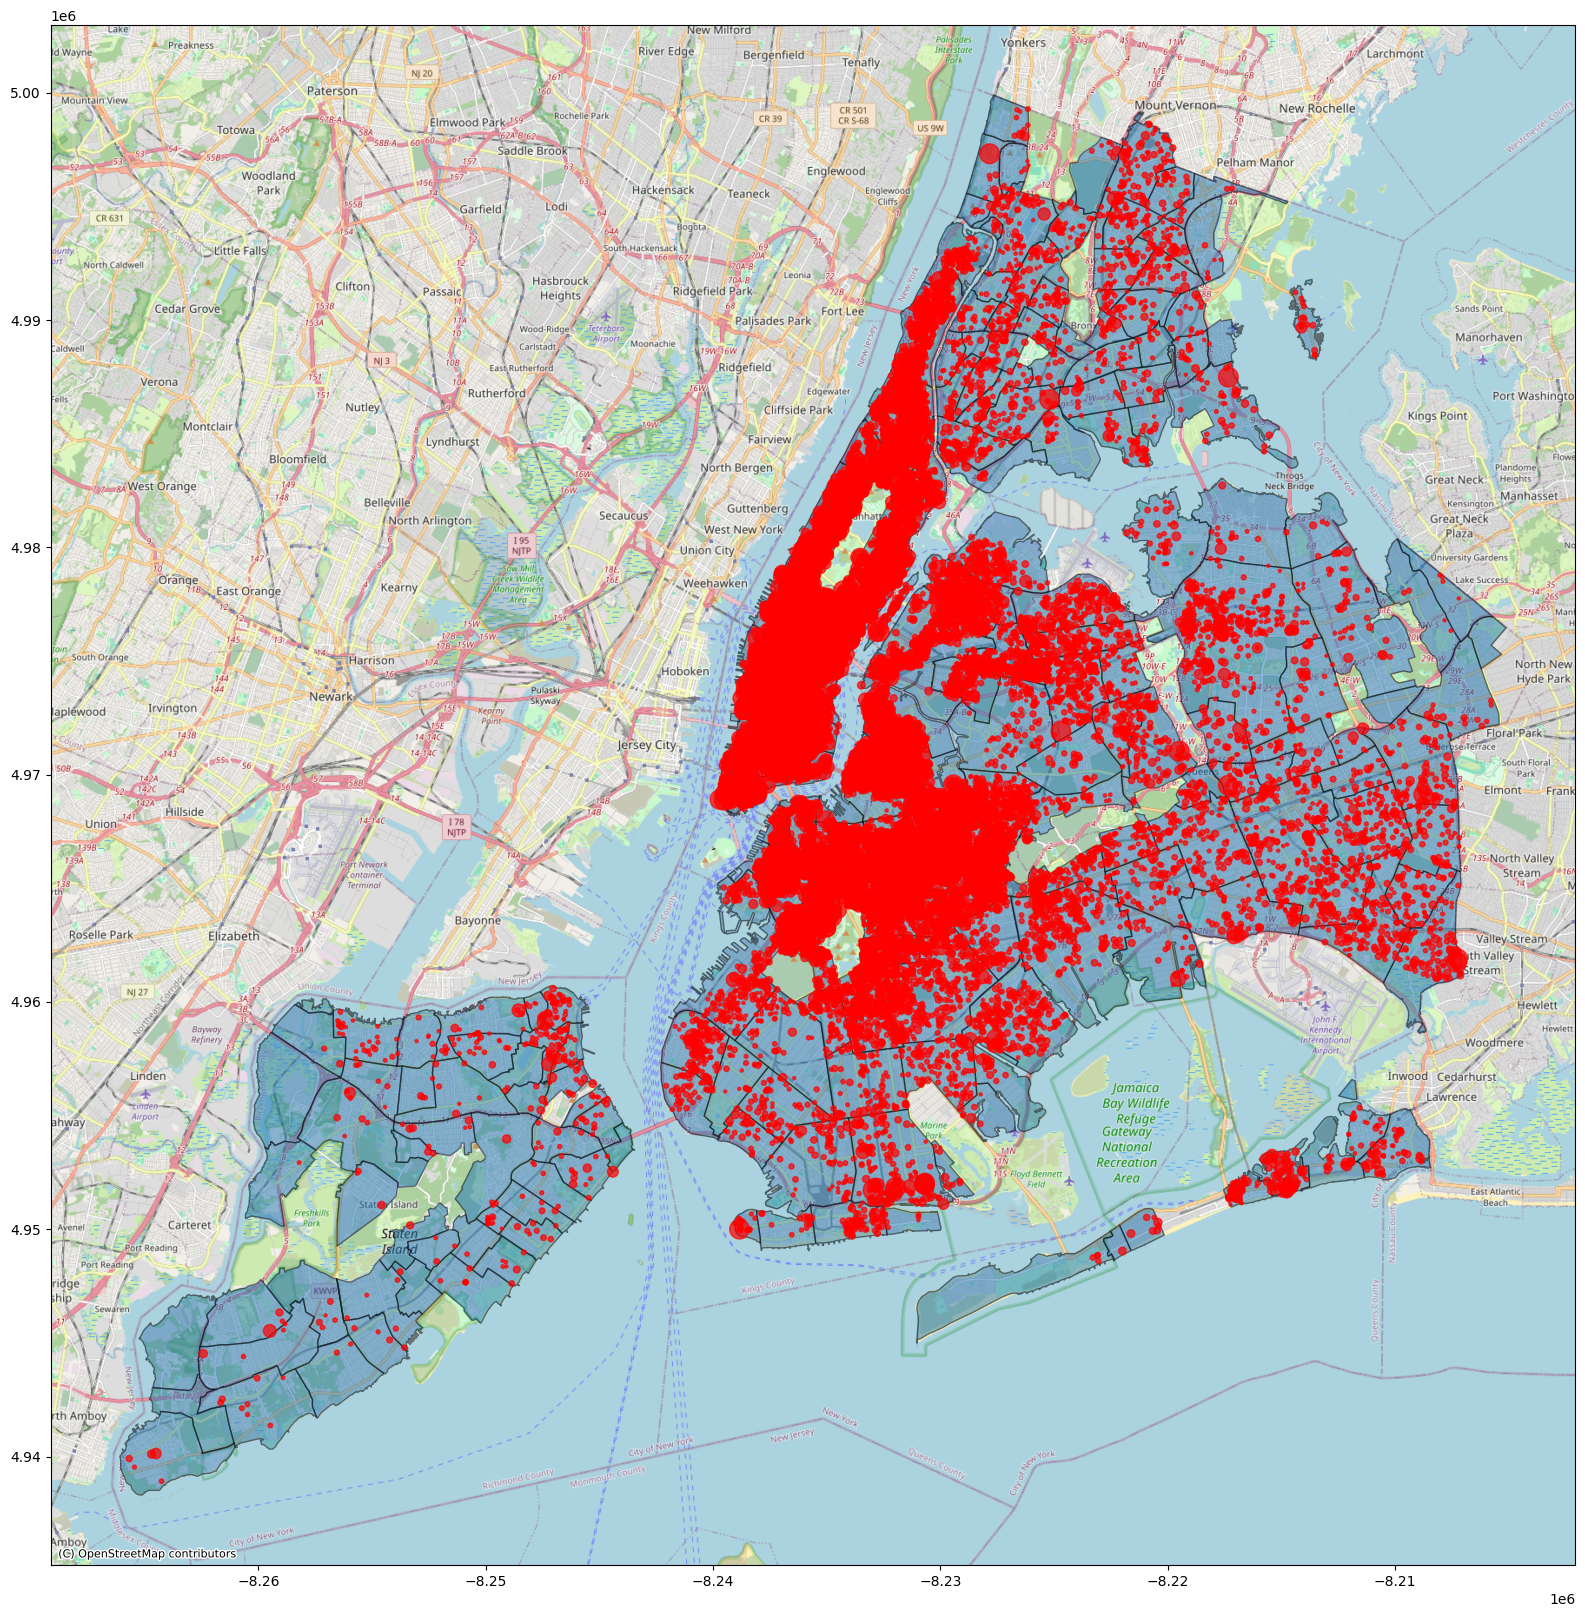

In [24]:
df = gpd.read_file(geopandas_city_path)
df_wm = df.to_crs(epsg=3857)

gdf_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    data=data
)
# As data is in the form of latitude and logitude
gdf_points.crs = {'init': 'epsg:4326'}  

# Converting it to Google map/ open street map
gdf_points_wm = gdf_points.to_crs(epsg=3857)

# Plotting new york city
ax = df_wm.plot(figsize=(20, 20), alpha=0.5, edgecolor="k")

# Bubble Size variation
min_size = 50
max_size = 2000
size_range = gdf_points_wm['price'].clip(min_size, max_size)

# Plotting bubble
gdf_points_wm.plot(ax=ax, color='red', alpha=0.7, markersize=size_range*0.1)


cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik,zoom=12)
plt.show()

SiLK Road

In [25]:
#I established connections by identifying the Silk Road in the graph. 
#This was achieved by creating a grid for all cities in the route and 
#setting the grid to 1 if there was a route between two cities.
city_df=pd.read_csv('Connections.csv')  
city_df.set_index('City', inplace=True)

#I selected a city, calculated its latitude and longitude, and stored the values in the dataframe.
df=pd.read_csv('City_l_T.csv')

In [26]:
city_positions={}
for i in range(len(df)):
    city_positions[df['city'][i]]=(df['longitude'][i],df['latitude'][i])

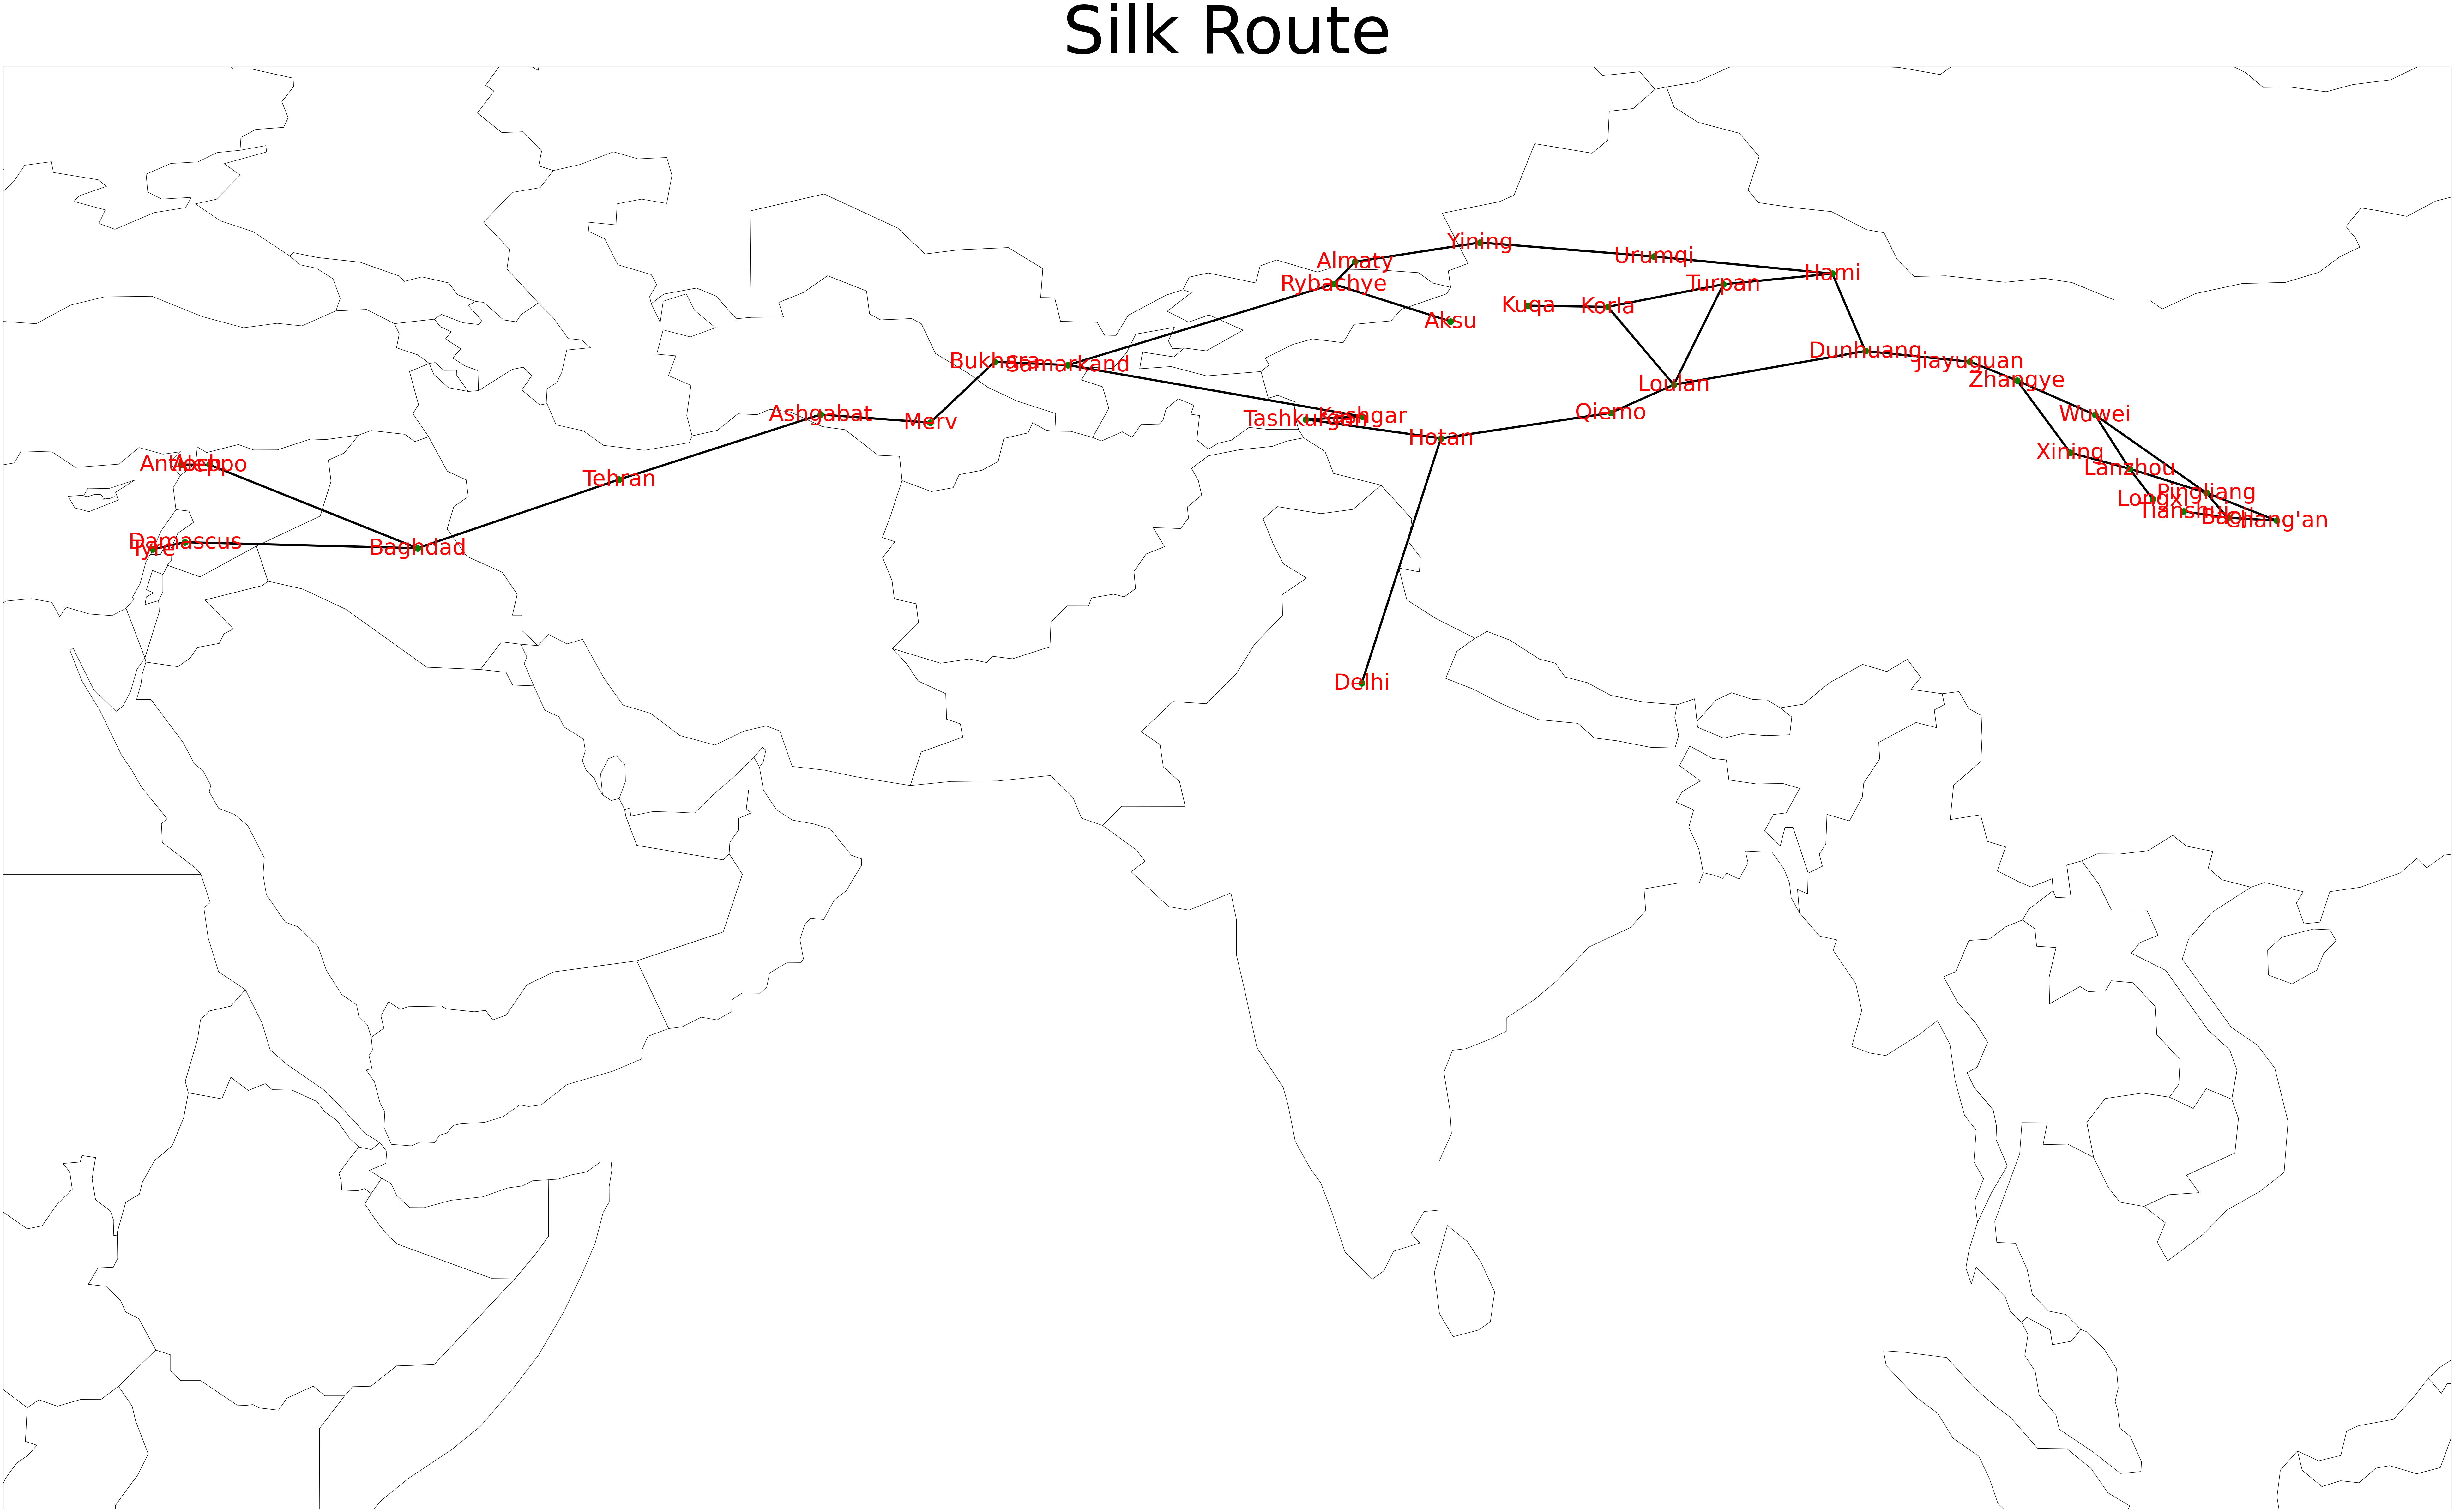

In [28]:
G = nx.Graph()
G.add_nodes_from(city_positions.keys(), pos=city_positions) #Putting all city in the graph

#Adding edge if grid of city contain 1
for i, row in city_df.iterrows():
    for j, value in enumerate(row):
        if value == 1:
            G.add_edge(i, city_df.columns[j])

#Taking background to world-Map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
world.plot(figsize=(100, 100), color='white', edgecolor='black')

#Plotting them on the map
nx.draw_networkx_nodes(G, pos=city_positions, node_color='green', node_size=200)  #City
nx.draw_networkx_edges(G, pos=city_positions, edge_color='black', width=5)   #Edge
nx.draw_networkx_labels(G, pos=city_positions, font_size=50, font_color='red')  #City Name

#For better look just focusing on route area only
plt.xlim(30, 115)
plt.ylim(0, 50)


plt.title('Silk Route', fontsize=150)  #Title
plt.show()
